In [2]:
#This code will give you several maps depending on different criterias. Feel free to adapt and change the criterias.
import xarray as xr 

dset_mars = xr.open_dataset('mola32.nc')
dset_mars

<xarray.Dataset>
Dimensions:    (latitude: 5760, longitude: 11520)
Coordinates:
  * latitude   (latitude) float32 89.98 89.95 89.92 ... -89.92 -89.95 -89.98
  * longitude  (longitude) float32 0.01562 0.04688 0.07812 ... 359.9 360.0 360.0
Data variables:
    alt        (latitude, longitude) int16 ...
Attributes:
    title:    MOLA Topography - 32 pixels/degree
    history:  Built from original MOLA file megt90n000fb.img

In [3]:
import pygmt 

# convert from int16 to float
dset_mars_topo = dset_mars.alt.astype(float)

dset_mars_topo = pygmt.grdsample(grid=dset_mars_topo,translate=True,spacing=[1,1])

# don't be worried about the warnings

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


In [42]:
#Read the data from a file made by extract_MRO_data
import pandas as pd

def read_data_from_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue 
            cleaned_line = line.strip("()\n").split(", ")
            cleaned_line[3:5] = [','.join(cleaned_line[3:5])]
            data.append(cleaned_line)
    df = pd.DataFrame(data, columns=["Date", "Latitude", "Longitude", "Altitude", "Start Time", "Stop Time", "Duration", "L_s","Event Type"])

    df[['Altitude Min', 'Altitude Max']] = df['Altitude'].str.extract(r'\[\s*(\d+\.\d+)\s*,\s*(\d+\.\d+)\s*\]').astype(float)

    df.drop('Altitude', axis=1, inplace=True)

    df['Date'] = df['Date'].str.strip("'")
    df['Event Type'] = df['Event Type'].str.strip("'")
    df['Latitude'] = df['Latitude'].str.strip("'").astype(float)
    df['Longitude'] = df['Longitude'].str.strip("'").astype(float)
    df['Start Time'] = df['Start Time'].astype(float)
    df['Stop Time'] = df['Stop Time'].astype(float)
    df['Duration'] = df['Duration'].astype(float)
    df['L_s'] = df['L_s'].str.strip("'").astype(float)

    return df

file_path = 'data_analysis.txt' 
df = read_data_from_file(file_path)

print(df.head())

         Date  Latitude  Longitude  Start Time  Stop Time   Duration  \
0  2017-05-01    58.330    174.291   10.455984   5.287752  -5.168232   
1  2017-05-01    47.138    138.907   11.667672  13.253616   1.585944   
2  2017-05-01    74.265      6.244    2.904984   3.180624   0.275640   
3  2017-05-01    56.777     96.417   10.720344   7.937232  -2.783112   
4  2017-05-01    65.287   -178.810   17.874264   5.317032 -12.557232   

         L_s     Event Type  Altitude Min  Altitude Max  
0  357.85662  precipitation         6.762         6.762  
1  357.93316  precipitation        22.102        22.948  
2  357.93598  precipitation         5.534         6.451  
3  357.97386  precipitation         4.619         4.619  
4  358.01332  precipitation         5.249         7.975  


In [43]:
df['Date'] = pd.to_datetime(df['Date'])

# Define intervals for each Martian Year
mars_years = {
    "Mars Year 34": ("2017-05-05", "2019-03-23"),
    "Mars Year 35": ("2019-03-23", "2021-02-07"),
    "Mars Year 36": ("2021-02-07", "2022-12-26")
}

# Create different dataframe for each year
dataframes = {}
for year, (start, end) in mars_years.items():
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    dataframes[year] = df.loc[mask]

print(dataframes["Mars Year 34"])
print(dataframes["Mars Year 35"])
print(dataframes["Mars Year 36"])

            Date  Latitude  Longitude  Start Time  Stop Time  Duration  \
33    2017-05-05    74.825   -147.425   13.397952  13.533960  0.136008   
34    2017-05-05    47.794   -174.352   11.638920  13.195968  1.557048   
35    2017-05-05    42.581    163.502   11.945520  13.521816  1.576296   
36    2017-05-05    53.152   -124.810   16.421448  13.377504 -3.043944   
37    2017-05-05    48.314    157.717   11.606352  13.159680  1.553328   
...          ...       ...        ...         ...        ...       ...   
10696 2019-03-23    78.307    170.353    3.275880  11.315040  8.039160   
10697 2019-03-23    85.161    163.382    5.465208  11.970984  6.505776   
10698 2019-03-23    83.057    151.731    4.148904   5.465208  1.316304   
10699 2019-03-23    81.001    145.831    3.570192   4.148904  0.578712   
10700 2019-03-23    60.664    131.670    2.488368   2.599704  0.111336   

             L_s     Event Type  Altitude Min  Altitude Max  
33     359.92411          cloud        18.694    

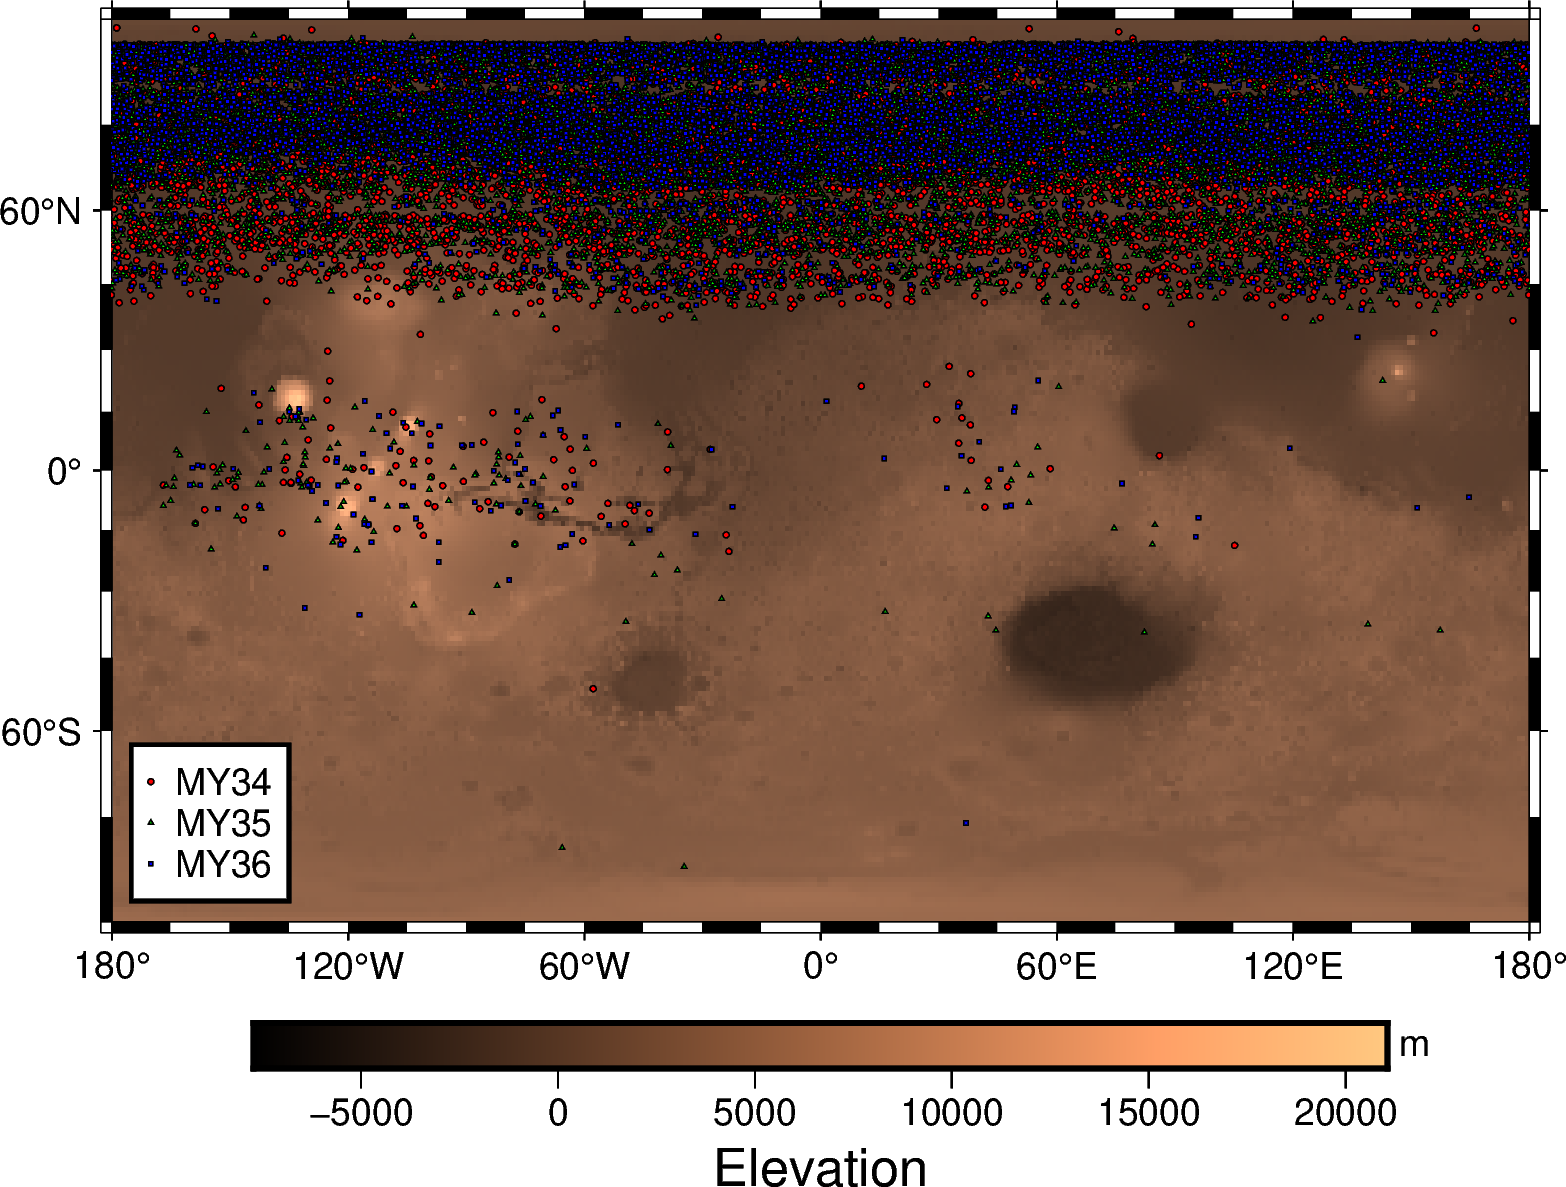

In [6]:
#Map different for each year. Don't forget to use the cell above before
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])

# Define the symbols for the legend
symbols = {
    "Mars Year 34": {"style": "c0.05c", "color": "red", "label": "MY34"},
    "Mars Year 35": {"style": "t0.05c", "color": "green", "label": "MY35"},
    "Mars Year 36": {"style": "s0.05c", "color": "blue", "label": "MY36"}
}
#Iterate on each Martian year
for year, df_year in dataframes.items():
    style = symbols[year]["style"]
    color = symbols[year]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[year]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-1.5c/-1.5c",box="+gwhite+p1p")
fig.show()
fig.savefig('carte Mars.png')

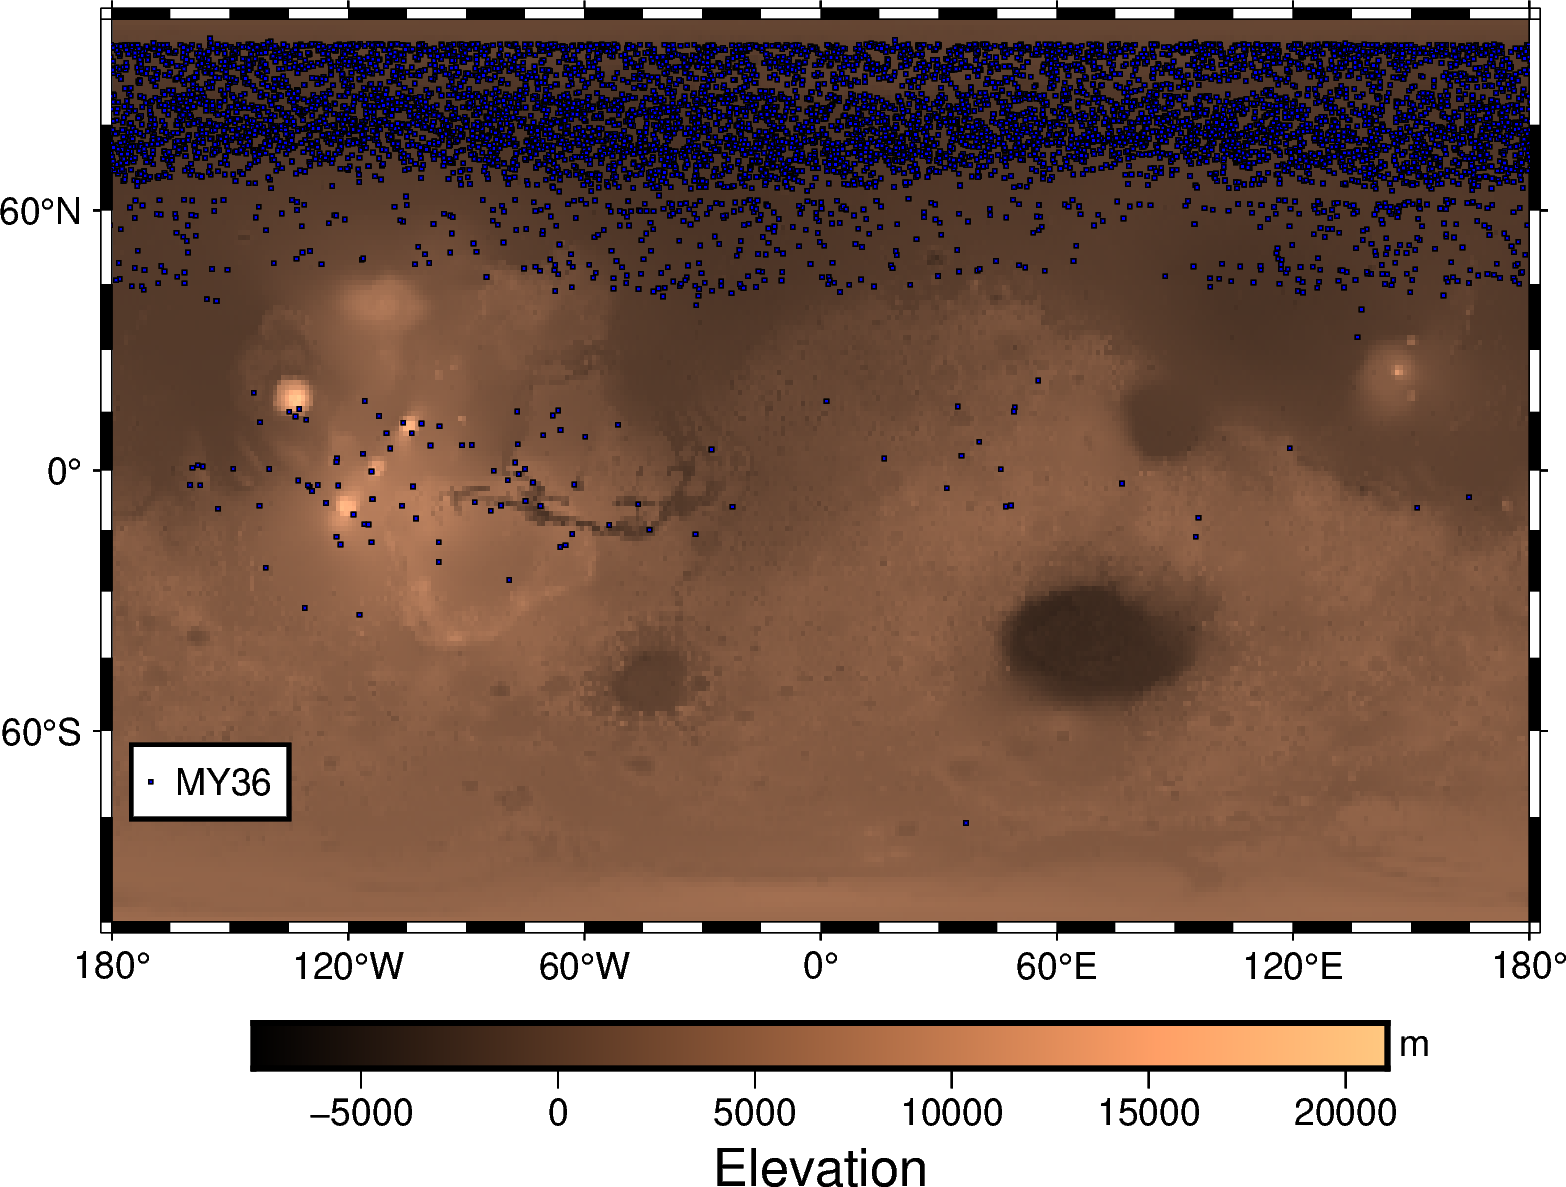

In [32]:
#Map for only one year.
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])


symbols = {
    "Mars Year 34": {"style": "c0.05c", "color": "red", "label": "MY34"},
    "Mars Year 35": {"style": "t0.05c", "color": "green", "label": "MY35"},
    "Mars Year 36": {"style": "s0.05c", "color": "blue", "label": "MY36"}
}

for year, df_year in dataframes.items():
    if year != "Mars Year 36": #Change the year here if needed
        continue
    style = symbols[year]["style"]
    color = symbols[year]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[year]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-1.5c/-1.5c",box="+gwhite+p1p")


fig.show()
fig.savefig('carte Mars_36.png')

In [5]:
#Separate the file by event type
import pandas as pd

# Find unique event types in the DataFrame
unique_event_types = df['Event Type'].unique()

# Create separate DataFrames for each event type
dataframes = {}
for event_type in unique_event_types:
    dataframes[event_type] = df[df['Event Type'] == event_type]

print(dataframes["cloud"])

             Date  Latitude  Longitude  Start Time  Stop Time  Duration  \
6      2017-05-01    51.399     24.286   11.341272  12.643560  1.302288   
8      2017-05-01    32.825   -170.651    0.589128   2.134152  1.545024   
10     2017-05-01    65.988    131.524    0.016584   2.557248  2.540664   
12     2017-05-02    78.363   -166.714   13.187088  13.388040  0.200952   
13     2017-05-02    53.771    111.237   16.446960  13.305888 -3.141072   
...           ...       ...        ...         ...        ...       ...   
29934  2022-12-25    -0.216   -114.087    2.404992   2.411112  0.006120   
29935  2022-12-25   -13.585   -115.902    2.356536   2.362920  0.006384   
29936  2022-12-26    -8.896   -142.526    2.376840   2.389944  0.013104   
29937  2022-12-26    70.368   -153.932    3.051720   3.119592  0.067872   
29938  2022-12-26    86.764    171.019   11.233200  12.579072  1.345872   

      Event Type  Altitude Min  Altitude Max  
6          cloud        16.211        17.974  
8    

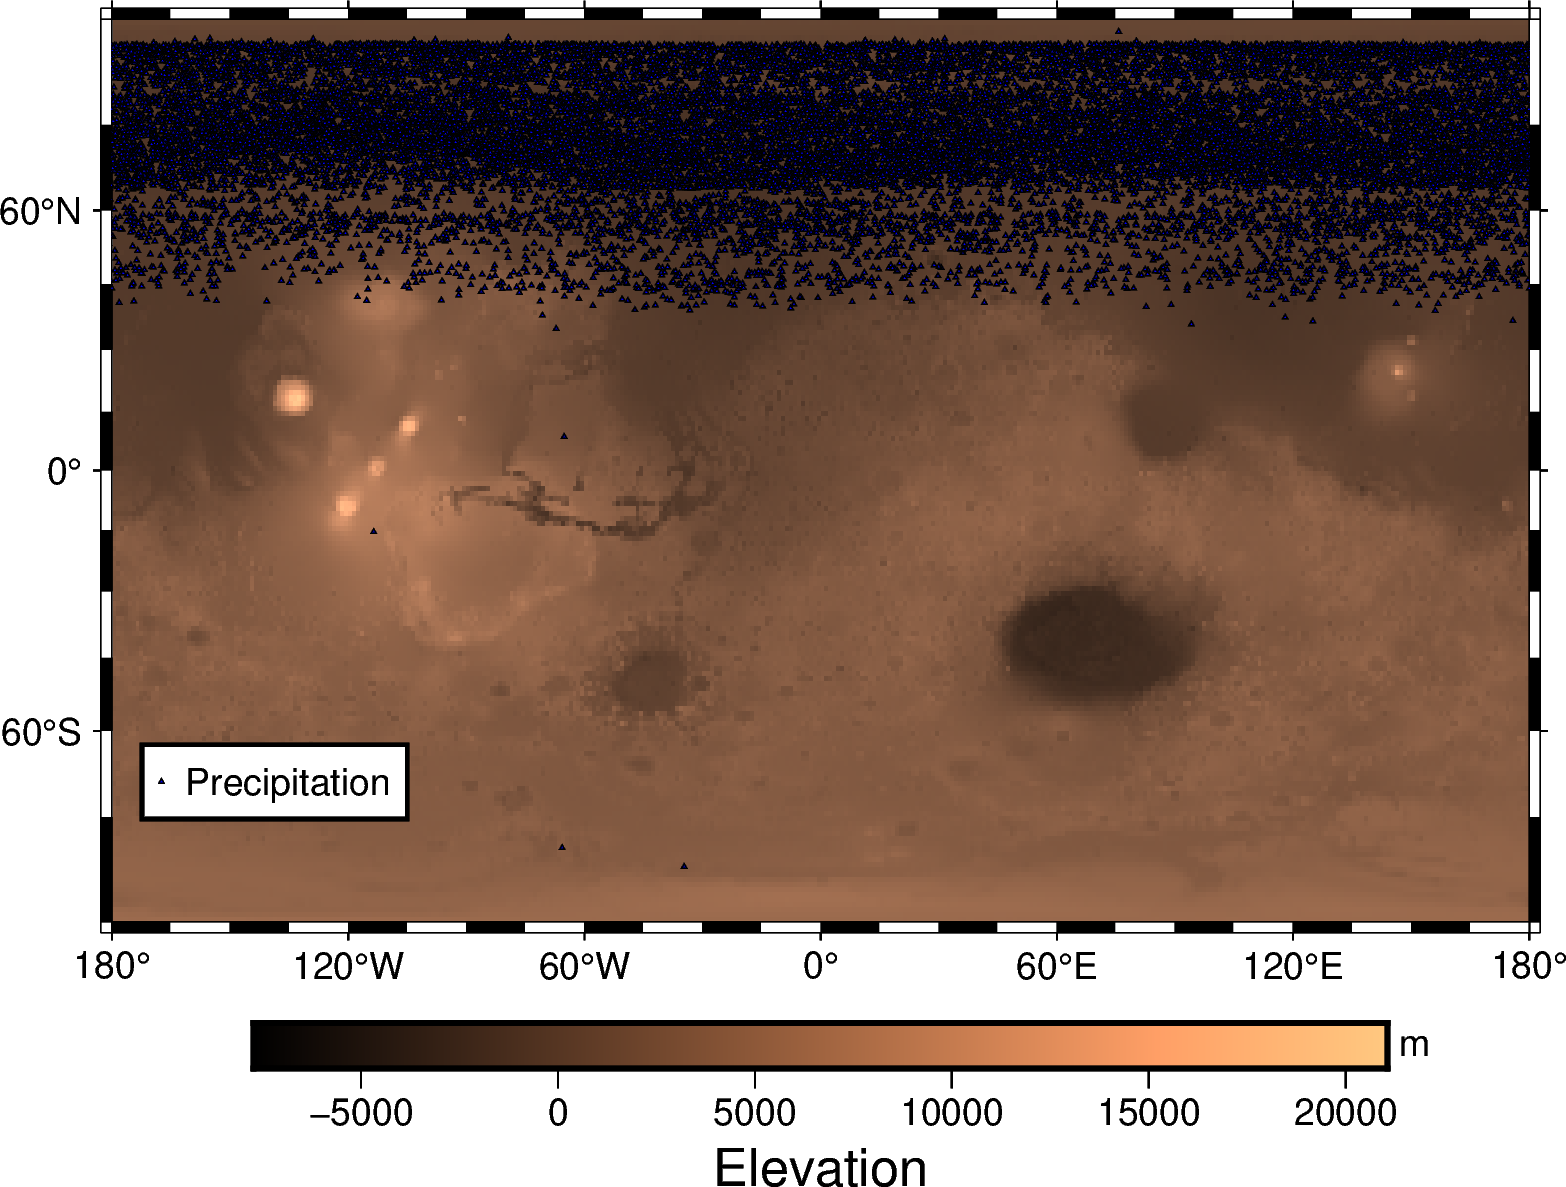

In [6]:
#Map for each event type, separated
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])

# Définir les symboles pour la légende
symbols = {
    "cloud": {"style": "c0.05c", "color": "white", "label": "Cloud"},
    "precipitation": {"style": "t0.05c", "color": "blue", "label": "Precipitation"},
}
# Itérer sur chaque année martienne et tracer les points
for year, df_year in dataframes.items():
    if year != "precipitation": #change here if you want the other one. You can remove this if if you want the two together.
        continue
    style = symbols[year]["style"]
    color = symbols[year]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[year]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-2.5c/-1.5c",box="+gwhite+p1p")

# Afficher la figure
fig.show()
fig.savefig('carte Mars_eventtypeprecipitation.png')

In [11]:

mars_altitude = {
    "altitude030": (0, 30),
    "altitude3060": (30, 60),
    "altitude6090": (60, 90),
}

dataframes = {}
for altitude, (start, end) in mars_altitude.items():
    mask = (df['Altitude Max'] >= start) & (df['Altitude Max'] <= end)
    dataframes[altitude] = df.loc[mask]

dataframes["altitude030"]


,Date,Latitude,Longitude,Start Time,Stop Time,Duration,Event Type,Altitude Min,Altitude Max
0,2017-05-01,58.330,174.291,10.455984,5.287752,-5.168232,precipitation,6.762,6.762
1,2017-05-01,47.138,138.907,11.667672,13.253616,1.585944,precipitation,22.102,22.948
2,2017-05-01,74.265,6.244,2.904984,3.180624,0.275640,precipitation,5.534,6.451
3,2017-05-01,56.777,96.417,10.720344,7.937232,-2.783112,precipitation,4.619,4.619
4,2017-05-01,65.287,-178.810,17.874264,5.317032,-12.557232,precipitation,5.249,7.975
...,...,...,...,...,...,...,...,...,...
29928,2022-12-24,46.468,-84.882,2.630544,2.911416,0.280872,cloud,25.002,29.181
29931,2022-12-25,82.279,158.172,13.108656,13.488072,0.379416,cloud,20.178,24.491
29932,2022-12-25,79.392,55.725,13.392264,13.515072,0.122808,precipitation,19.246,20.977
29937,2022-12-26,70.368,-153.932,3.051720,3.119592,0.067872,cloud,23.396,25.959


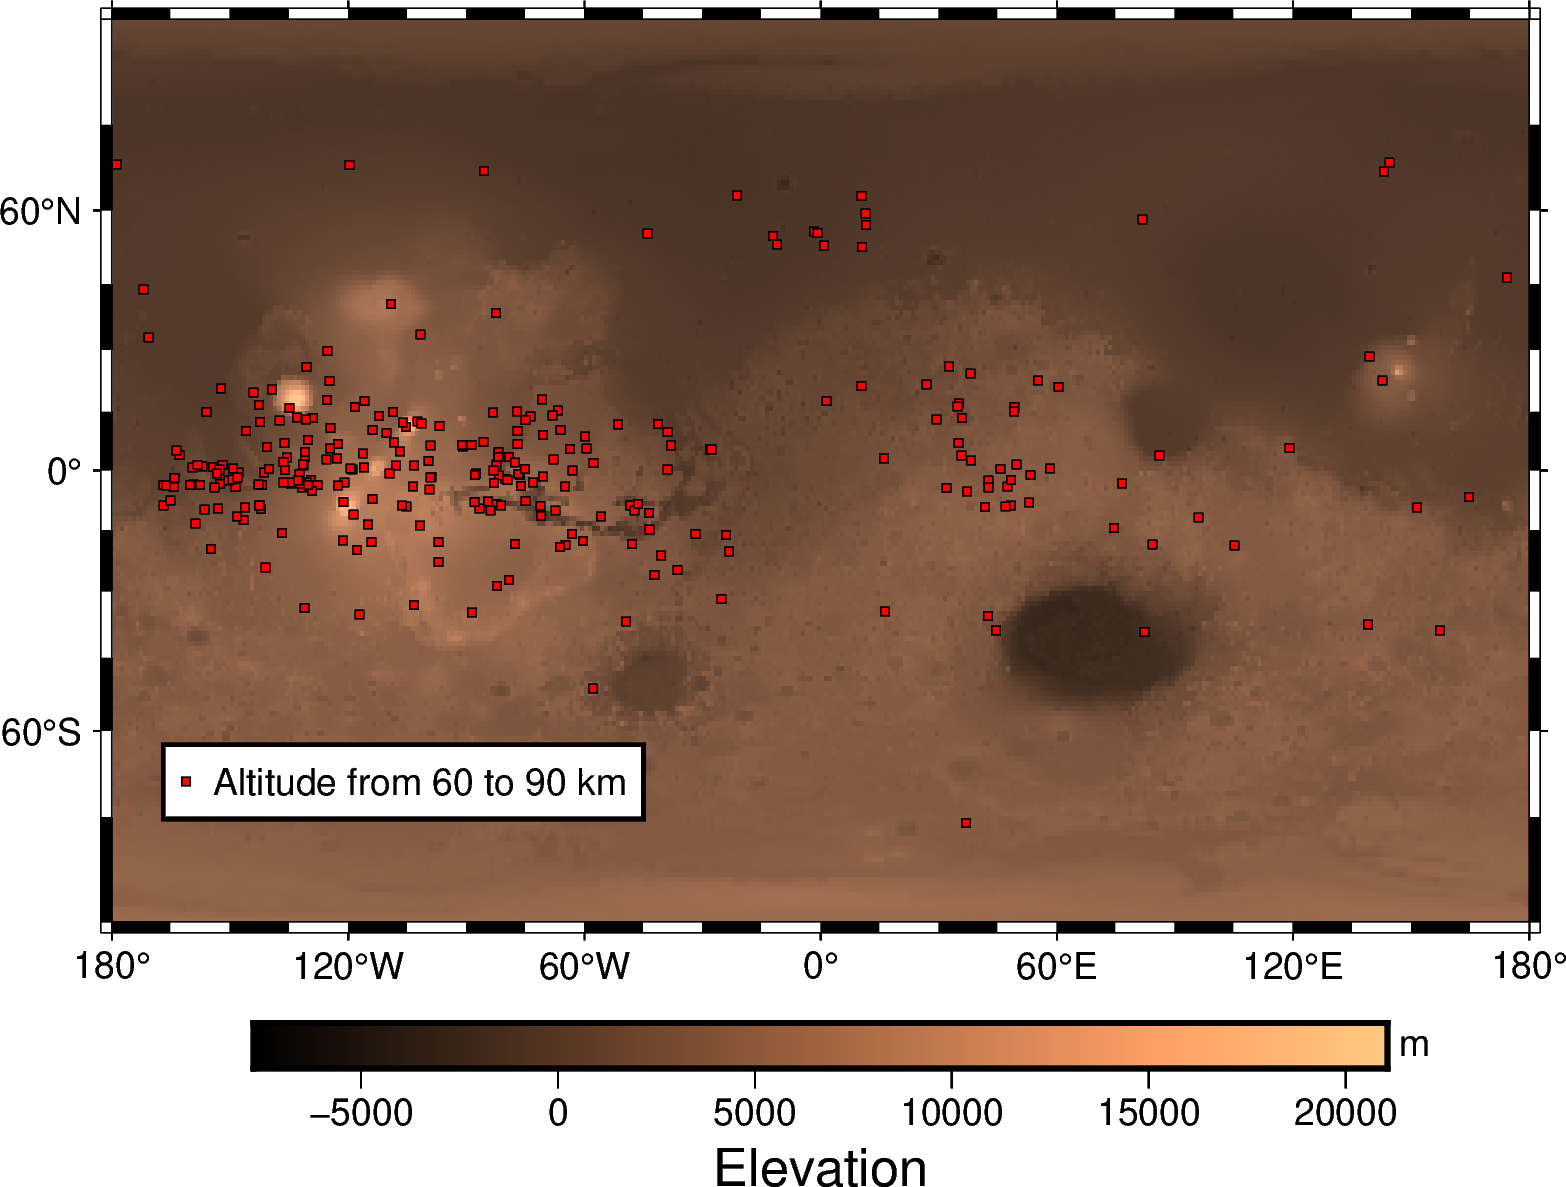

In [16]:
#Same as before but for alti
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])

symbols = {
    "altitude030": {"style": "c0.1c", "color": "lightblue", "label": "Altitude from 0 to 30km"},
    "altitude3060": {"style": "t0.1c", "color": "orange", "label": "Altitude from 30 to 60km"},
    "altitude6090": {"style": "s0.1c", "color": "red", "label": "Altitude from 60 to 90 km"},
}
for altitude, df_year in dataframes.items():
    if altitude != "altitude6090":
        continue
    style = symbols[altitude]["style"]
    color = symbols[altitude]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[altitude]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-4.5c/-1.5c",box="+gwhite+p1p")
# Afficher la figure
fig.show()
fig.savefig('carte Mars_altitude6090.png')

In [8]:
print(max(df.Duration))

17.750232


In [41]:
# Définir les intervalles pour chaque année martienne
mars_duration = {
    "duration03": (0, 0.5),
    "duration36": (0.5, 1),
    "duration69": (1, 3),
    "duration912": (3, 4),
    "duration1215": (4, 18),
}

# Créer des DataFrames séparés pour chaque année martienne
dataframes = {}
for duration, (start, end) in mars_duration.items():
    mask = (df['Duration'] >= start) & (df['Duration'] <= end)
    dataframes[duration] = df.loc[mask]

dataframes["duration03"]

,Date,Latitude,Longitude,Start Time,Stop Time,Duration,L_s,Event Type,Altitude Min,Altitude Max
2,2017-05-01,74.265,6.244,2.904984,3.180624,0.275640,357.93598,precipitation,5.534,6.451
12,2017-05-02,78.363,-166.714,13.187088,13.388040,0.200952,358.40275,cloud,21.268,26.331
17,2017-05-03,74.479,-74.013,13.474344,13.563336,0.088992,358.79323,cloud,24.147,25.859
19,2017-05-03,79.391,169.535,13.129704,13.243296,0.113592,358.94997,precipitation,19.491,21.227
22,2017-05-03,82.334,-0.721,12.852528,13.012224,0.159696,359.18449,precipitation,4.202,6.064
...,...,...,...,...,...,...,...,...,...,...
35333,2022-12-25,13.778,-112.162,2.458896,2.465352,0.006456,359.74583,cloud,57.959,60.916
35334,2022-12-25,-0.216,-114.087,2.404992,2.411112,0.006120,359.74743,cloud,57.269,59.507
35335,2022-12-25,-13.585,-115.902,2.356536,2.362920,0.006384,359.74890,cloud,55.411,55.411
35336,2022-12-26,-8.896,-142.526,2.376840,2.389944,0.013104,359.78725,cloud,57.376,63.360


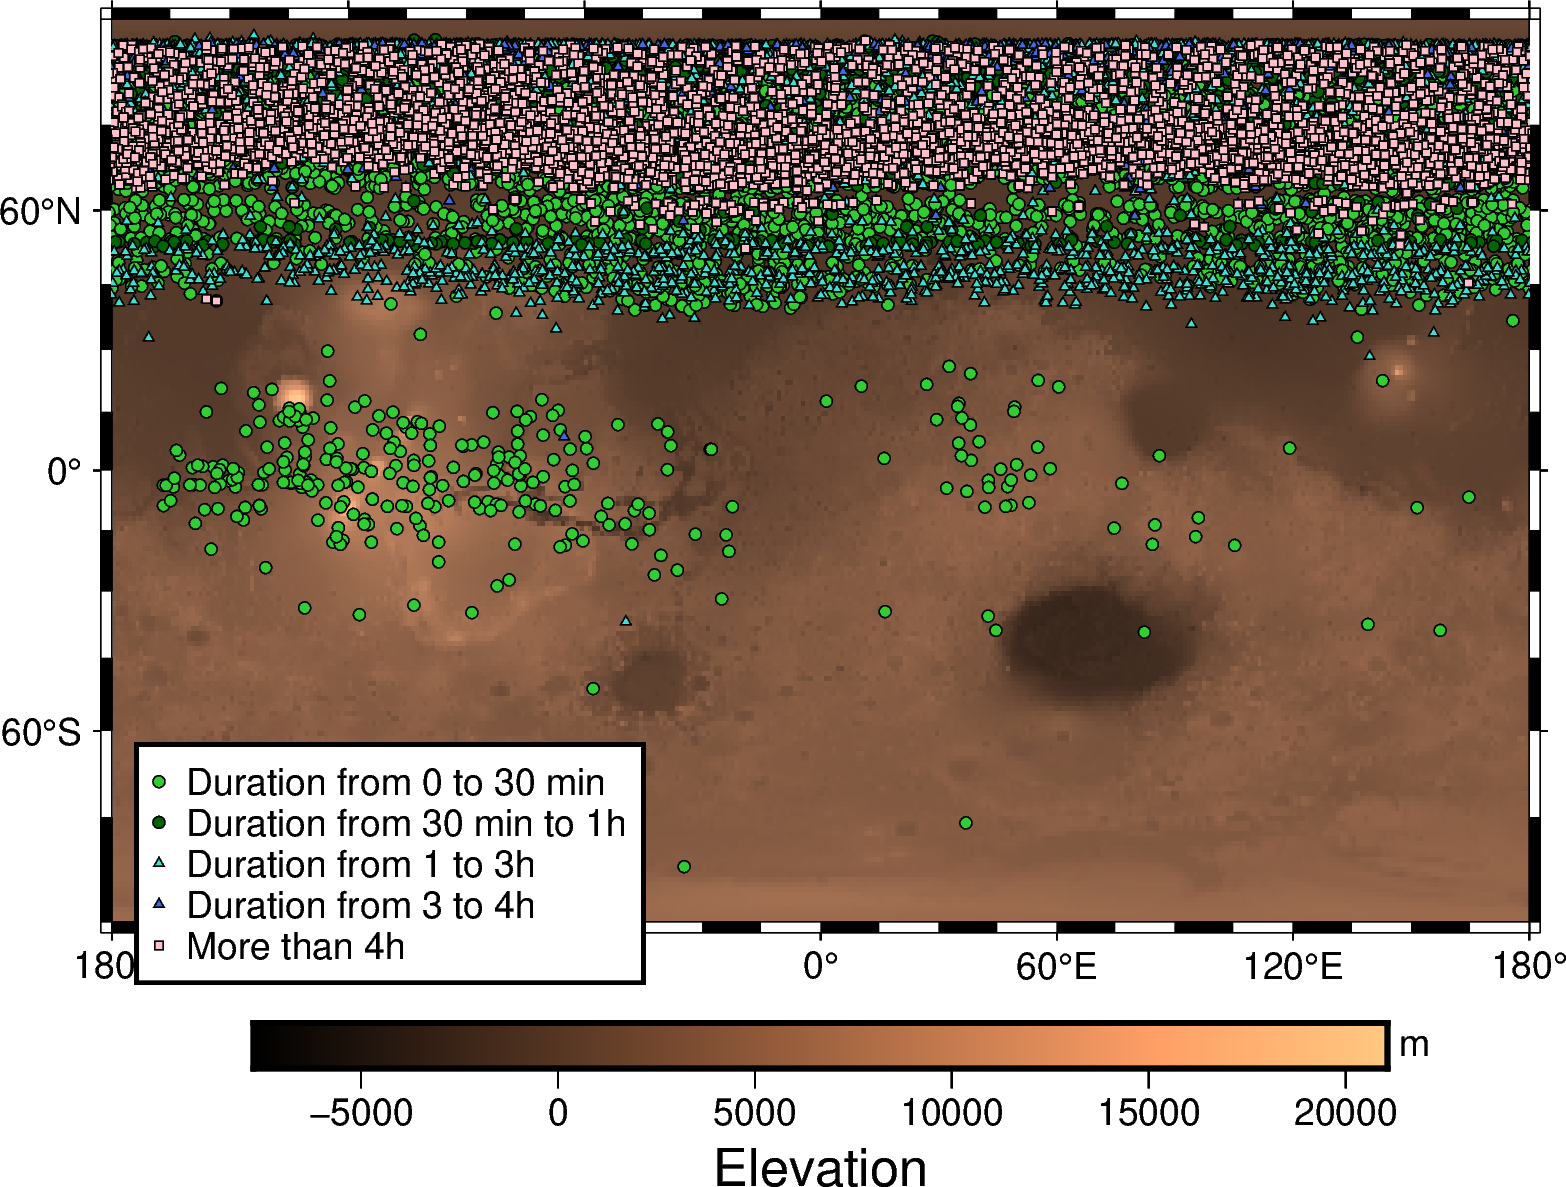

In [22]:
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])

# Définir les symboles pour la légende
symbols = {
    "duration03": {"style": "c0.1c", "color": "limegreen", "label": "Duration from 0 to 30 min"},
    "duration36": {"style": "c0.1c", "color": "darkgreen", "label": "Duration from 30 min to 1h"},
    "duration69": {"style": "t0.1c", "color": "turquoise", "label": "Duration from 1 to 3h"},
    "duration912": {"style": "t0.1c", "color": "royalblue", "label": "Duration from 3 to 4h"},
    "duration1215": {"style": "s0.1c", "color": "pink", "label": "More than 4h"},
}
# Itérer sur chaque année martienne et tracer les points
for duration, df_year in dataframes.items():
    style = symbols[duration]["style"]
    color = symbols[duration]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[duration]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-4.5c/-1.5c",box="+gwhite+p1p")
# Afficher la figure
fig.show()
fig.savefig('carte Mars_duration.png')

In [73]:
mars_Ls = {
    "Ls1": (270, 280),
    "Ls2": (280, 290),
    "Ls3": (290, 300),
    "Ls4": (300, 310),
    "Ls5": (310, 320),
    "Ls6": (320, 330),
    "Ls7": (330, 340),
    "Ls8": (340, 350),
    "Ls9": (350, 360),
}

# Créer des DataFrames séparés pour chaque année martienne
dataframes = {}
for Ls, (start, end) in mars_Ls.items():
    mask = (df['L_s'] >= start) & (df['L_s'] <= end)
    dataframes[Ls] = df.loc[mask]

dataframes['Ls1']

start_date = pd.to_datetime('2021-02-07')
end_date = pd.to_datetime('2022-12-26')

# Create separate DataFrames for each L_s range after filtering by date
filtered_dataframes = {}
for Ls in dataframes:
    # Apply the date filter
    dataframes[Ls] = dataframes[Ls][(dataframes[Ls]['Date'] >= start_date) & (dataframes[Ls]['Date'] <= end_date)]

dataframes['Ls6']



,Date,Latitude,Longitude,Start Time,Stop Time,Duration,L_s,Event Type,Altitude Min,Altitude Max
30194,2022-10-12,84.836,-125.102,12.277848,12.667968,0.390120,320.03124,cloud,13.141,14.926
30195,2022-10-12,83.318,123.423,4.747344,11.674968,6.927624,320.03246,cloud,11.151,26.712
30196,2022-10-12,80.325,113.432,3.786192,4.747344,0.961152,320.03286,precipitation,7.717,31.775
30197,2022-10-12,78.808,110.465,3.532824,3.786192,0.253368,320.03306,cloud,10.487,30.936
30198,2022-10-12,74.141,104.827,3.095928,3.532824,0.436896,320.03366,precipitation,12.723,29.990
...,...,...,...,...,...,...,...,...,...,...
31310,2022-10-30,82.820,16.170,4.492296,5.290032,0.797736,329.96092,precipitation,15.050,31.104
31311,2022-10-30,82.334,14.298,4.301424,4.492296,0.190872,329.96099,cloud,14.010,31.910
31312,2022-10-30,73.008,-0.576,3.004056,4.301424,1.297368,329.96216,precipitation,8.403,31.125
31313,2022-10-30,69.852,-2.630,2.862552,2.975928,0.113376,329.96255,precipitation,23.794,23.794


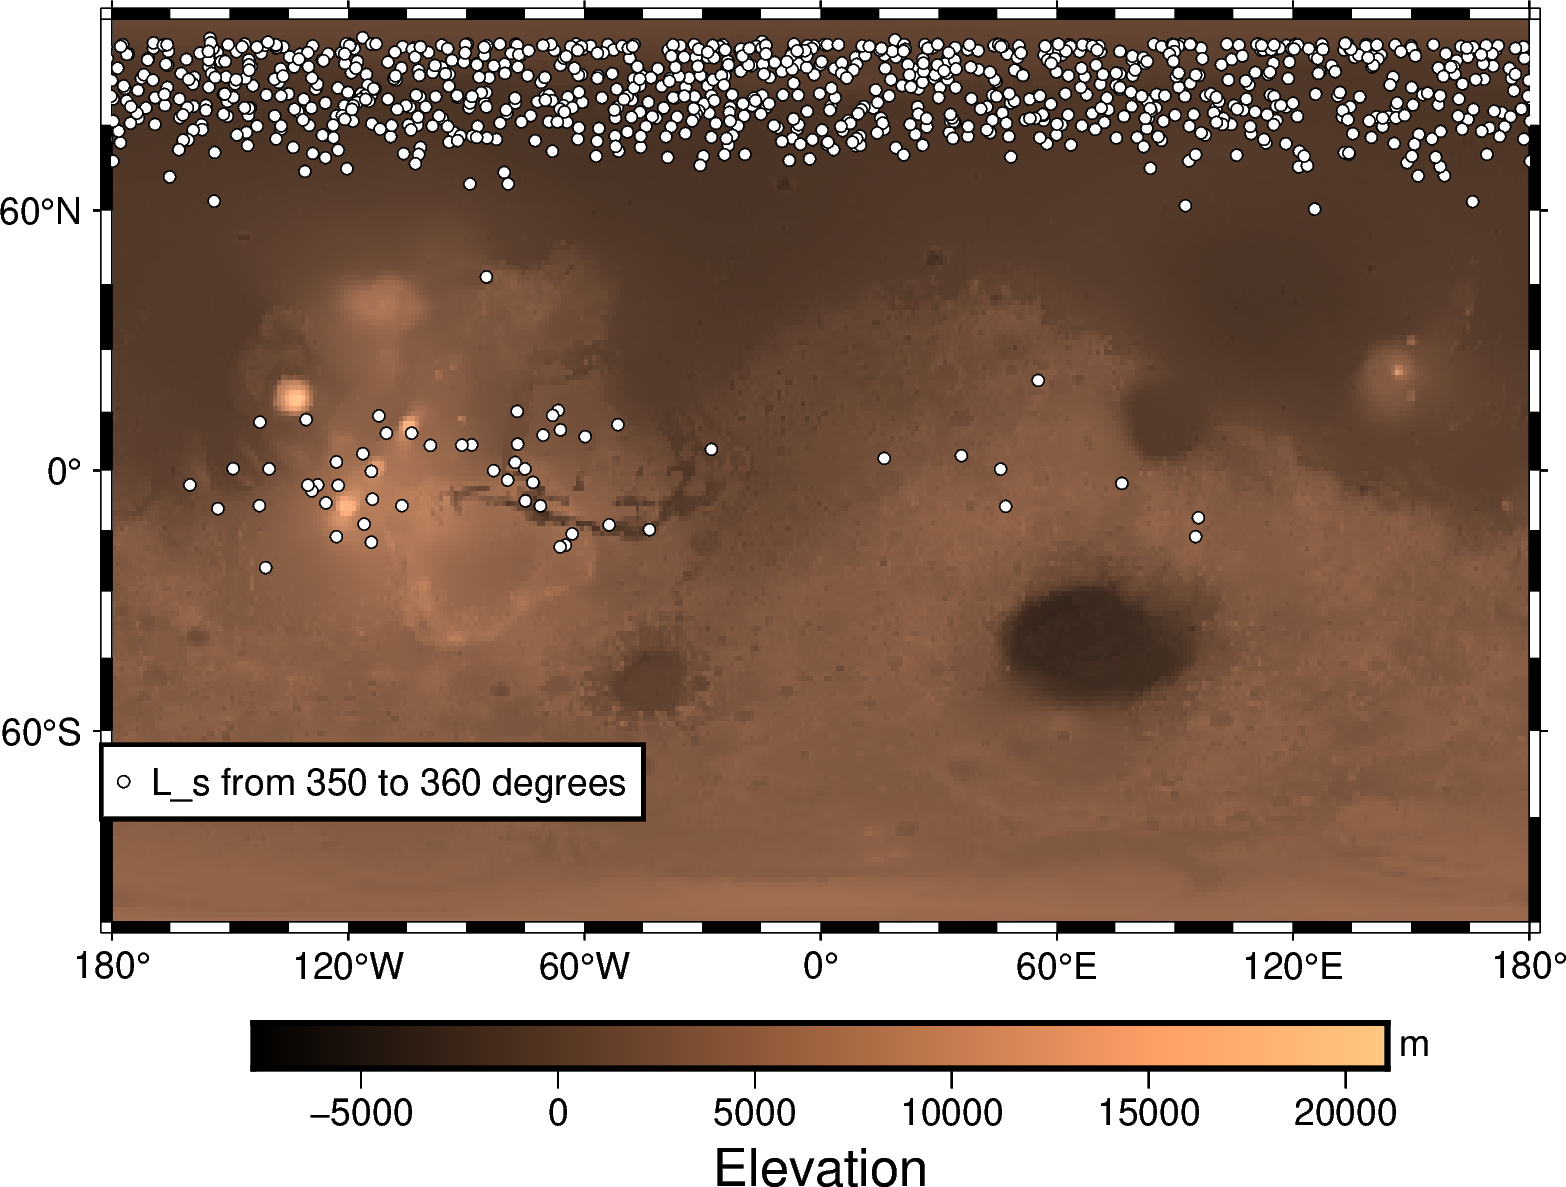

In [82]:
import pygmt

fig = pygmt.Figure()
fig.grdimage(grid=dset_mars_topo, region='g', frame=True, projection='Cyl_stere/0/0/12c', cmap='copper', shading='0.2')
fig.colorbar(frame=["a5000", "x+lElevation", "y+lm"])

# Définir les symboles pour la légende
symbols = {
    "Ls1": {"style": "c0.1c", "color": "white", "label": "L_s from 270 to 280 degrees"},
    "Ls2": {"style": "c0.1c", "color": "white", "label": "L_s from 280 to 290 degrees"},
    "Ls3": {"style": "c0.1c", "color": "white", "label": "L_s from 290 to 300 degrees"},
    "Ls4": {"style": "c0.1c", "color": "white", "label": "L_s from 300 to 310 degrees"},
    "Ls5": {"style": "c0.1c", "color": "white", "label": "L_s from 310 to 320 degrees"},
    "Ls6": {"style": "c0.1c", "color": "white", "label": "L_s from 320 to 330 degrees"},
    "Ls7": {"style": "c0.1c", "color": "white", "label": "L_s from 330 to 340 degrees"},
    "Ls8": {"style": "c0.1c", "color": "white", "label": "L_s from 340 to 350 degrees"},
    "Ls9": {"style": "c0.1c", "color": "white", "label": "L_s from 350 to 360 degrees"},

}
# Itérer sur chaque année martienne et tracer les points
for duration, df_year in dataframes.items():
    if duration != "Ls9":
        continue
    style = symbols[duration]["style"]
    color = symbols[duration]["color"]
    yearcheck = True
    for latitude, longitude in zip(df_year['Latitude'], df_year['Longitude']):
        if yearcheck:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black",label=symbols[duration]['label'])
            yearcheck = False
        else:
            fig.plot(x=longitude, y=latitude, style=style, fill=color, pen="black")
    
fig.legend(position="JBL+o-4.5c/-1.5c",box="+gwhite+p1p")
# Afficher la figure
fig.show()
fig.savefig('carte Mars_Ls35036036.png')